# Лабораторна робота №3
Гудима Анастасія

# Завдання 

Побудувати CNN на основі Xception для класифікації зображень на основі
датасету fashion-mnist.
Зробити налаштування моделі для досягнення необхідної точності. На базі
Siamese networks побудувати систему для пошуку подібних зображень в
датасеті fashion-mnist. Візуалізувати отримані результати t-SNE.


Варіант - 7


In [ ]:
import os
import numpy as np
import pandas as pd
from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
x_train, x_test = x_train[:8000], x_test[:1000]
y_train, y_test = y_train[:8000], y_test[:1000]

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (8000, 28, 28, 1) 1.0
Testing (1000, 28, 28, 1) 1.0


групування по лейблам

In [ ]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [747, 860, 809, 807, 763, 795, 807, 818, 792, 802]
test groups: [107, 105, 111, 93, 115, 87, 97, 95, 95, 95]


In [ ]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

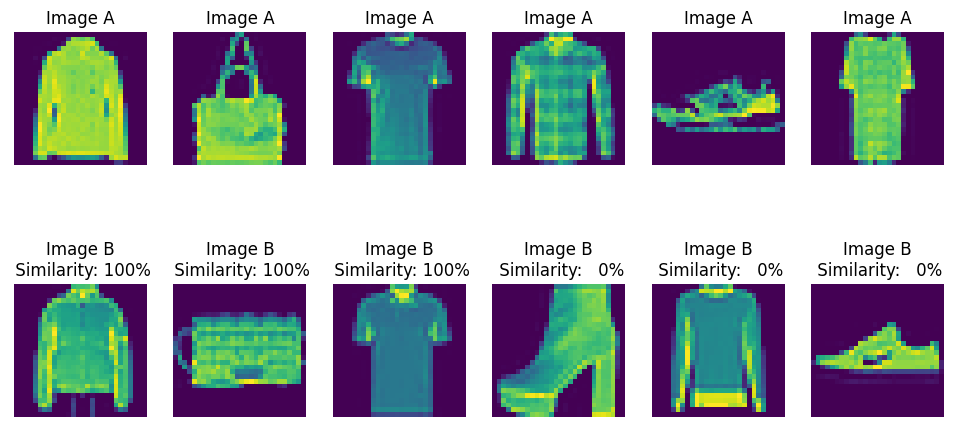

In [ ]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

img_in = Input(shape=x_train.shape[1:], name='FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size=(3,3), activation='linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size=(3,3), activation='linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation='linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs=[img_in], outputs=[n_layer], name='FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureNet_ImageInput (Inpu  [(None, 28, 28, 1)]      0         
 tLayer)                                                         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24,

In [ ]:
from keras.layers import concatenate
img_a_in = Input(shape=x_train.shape[1:], name='ImageA_Input')
img_b_in = Input(shape=x_train.shape[1:], name='ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = Dense(16, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation='sigmoid')(combined_features)
similarity_model = Model(inputs=[img_a_in, img_b_in], outputs=[combined_features], name='Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 32)          25040       ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 64)           0           ['FeatureGeneratio

In [ ]:
similarity_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

In [ ]:
def find_simmilar(dataset, image, n_candidates=1024, finalists=4):
    candidates, preds = [], []
    for i in range(n_candidates):
        candidates.append(dataset[np.random.choice(range(len(dataset)))])
    compiled = [np.tile(image, (n_candidates, 1, 1, 1)), np.stack(candidates)]
    print(compiled[0].shape, compiled[1].shape)
    preds = similarity_model.predict(compiled).reshape(-1)
    print(preds.shape)
    top = np.argpartition(preds, -finalists)[-finalists:]
    for i in top:
        plt.imshow(candidates[i][:, :, 0])
        plt.show()
        print(preds[i])

1/1 [==============================] - 9s 9s/step


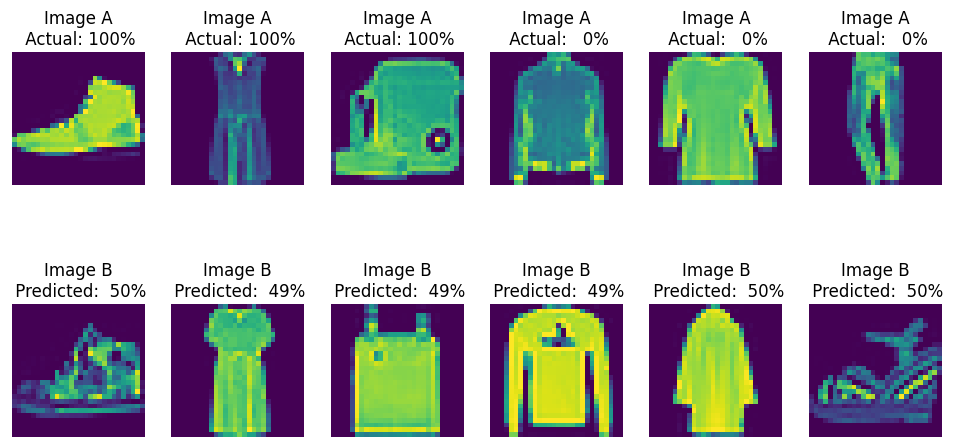

In [ ]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [ ]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(
    siam_gen(train_groups),
    steps_per_epoch=500,
    validation_data=([valid_a, valid_b], valid_sim),
    epochs=10,
    verbose=True
)

Epoch 1/10
500/500 [==============================] - 20s 19ms/step - loss: 0.6761 - mae: 0.4764 - val_loss: 0.5881 - val_mae: 0.4318
Epoch 2/10
500/500 [==============================] - 9s 18ms/step - loss: 0.5488 - mae: 0.3907 - val_loss: 0.4824 - val_mae: 0.3276
Epoch 3/10
500/500 [==============================] - 9s 18ms/step - loss: 0.4871 - mae: 0.3388 - val_loss: 0.4095 - val_mae: 0.2772
Epoch 4/10
500/500 [==============================] - 10s 21ms/step - loss: 0.4415 - mae: 0.2963 - val_loss: 0.3813 - val_mae: 0.2388
Epoch 5/10
500/500 [==============================] - 9s 18ms/step - loss: 0.4070 - mae: 0.2686 - val_loss: 0.3537 - val_mae: 0.2145
Epoch 6/10
500/500 [==============================] - 8s 17ms/step - loss: 0.3866 - mae: 0.2533 - val_loss: 0.3389 - val_mae: 0.2108
Epoch 7/10
500/500 [==============================] - 10s 19ms/step - loss: 0.3779 - mae: 0.2464 - val_loss: 0.3337 - val_mae: 0.1930
Epoch 8/10
500/500 [==============================] - 11s 21ms/ste

1/1 [==============================] - 0s 26ms/step


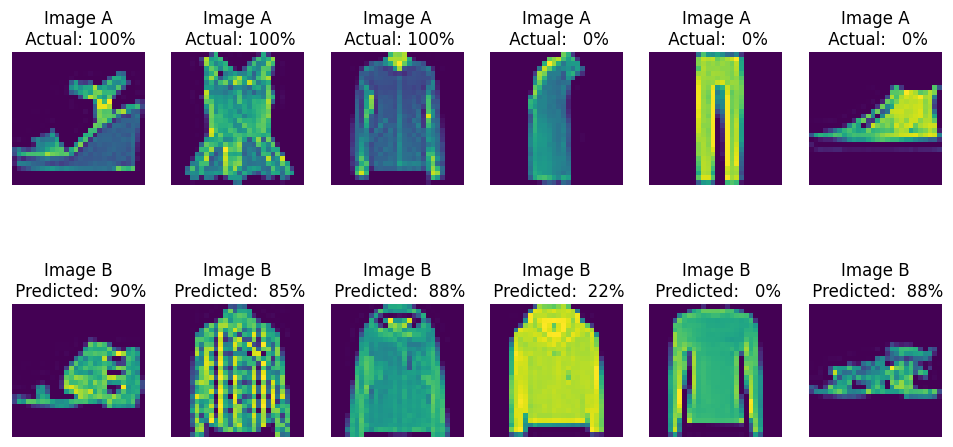

In [ ]:
_ = show_model_output()

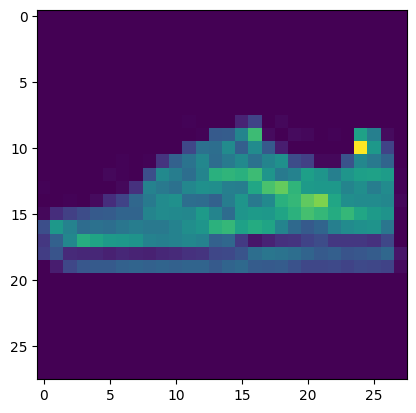

In [ ]:
image = x_train[666]
plt.imshow(image[:, :, 0])

(1024, 28, 28, 1) (1024, 28, 28, 1)
32/32 [==============================] - 0s 3ms/step
(1024,)


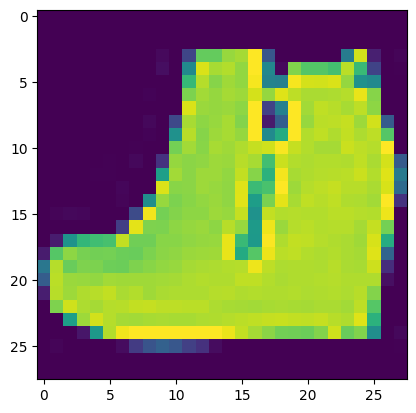

0.90638757


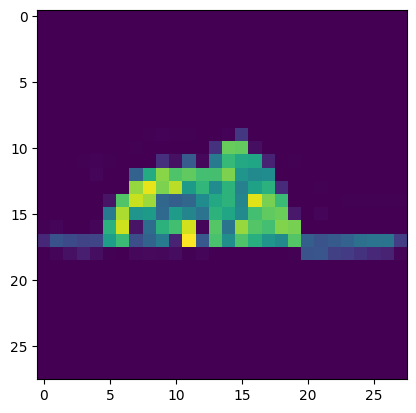

0.91643924


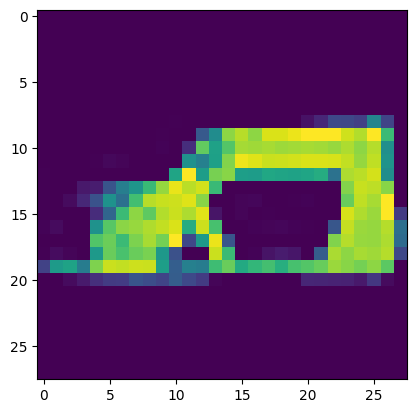

0.9093555


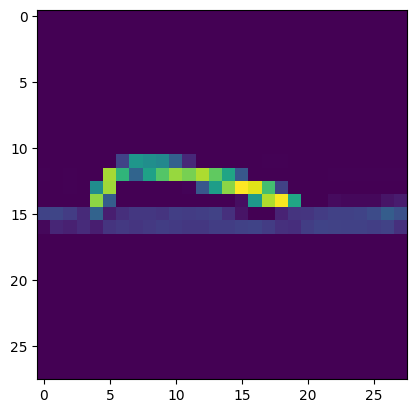

0.9114743


In [ ]:
find_simmilar(x_train, image)

In [ ]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0], 0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose=True, batch_size=128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0], 0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose=True, batch_size=128)

8/8 [==============================] - 0s 4ms/step


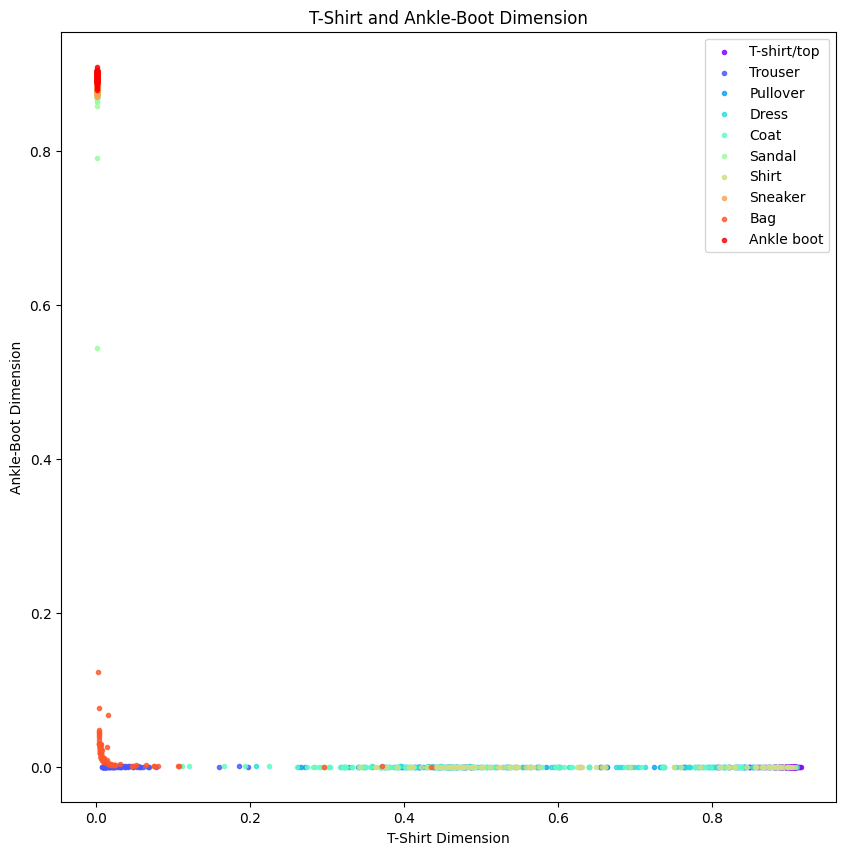

In [ ]:
obj_categories = [
    'T-shirt/top','Trouser','Pullover','Dress',
    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        t_shirt_score[np.where(y_test == c_group), 0],
        ankle_boot_score[np.where(y_test == c_group), 0],
        marker='.',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label
    )
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('dimension.png')

In [ ]:
x_test_features = feature_model.predict(
    x_test,
    verbose=True,
    batch_size=128
)

8/8 [==============================] - 0s 4ms/step


In [ ]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(
    n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.342s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.251667
[t-SNE] Computed conditional probabilities in 0.071s
[t-SNE] Iteration 50: error = 57.1362381, gradient norm = 0.0467807 (50 iterations in 0.882s)
[t-SNE] Iteration 100: error = 54.0610924, gradient norm = 0.0111975 (50 iterations in 0.240s)
[t-SNE] Iteration 150: error = 53.4829407, gradient norm = 0.0068144 (50 iterations in 0.232s)
[t-SNE] Iteration 200: error = 53.2465591, gradient norm = 0.0071625 (50 iterations in 0.263s)
[t-SNE] Iteration 250: error = 53.1024704, gradient norm = 0.0043559 (50 iterations in 0.230s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.102470
[t-SNE] Iteration 300: error = 0.7515248, gradient norm = 0.0158042 (50 iterations in 0.258s)
[t-SNE] Iteration 350: error = 0.5736833, gradient norm = 0.01168

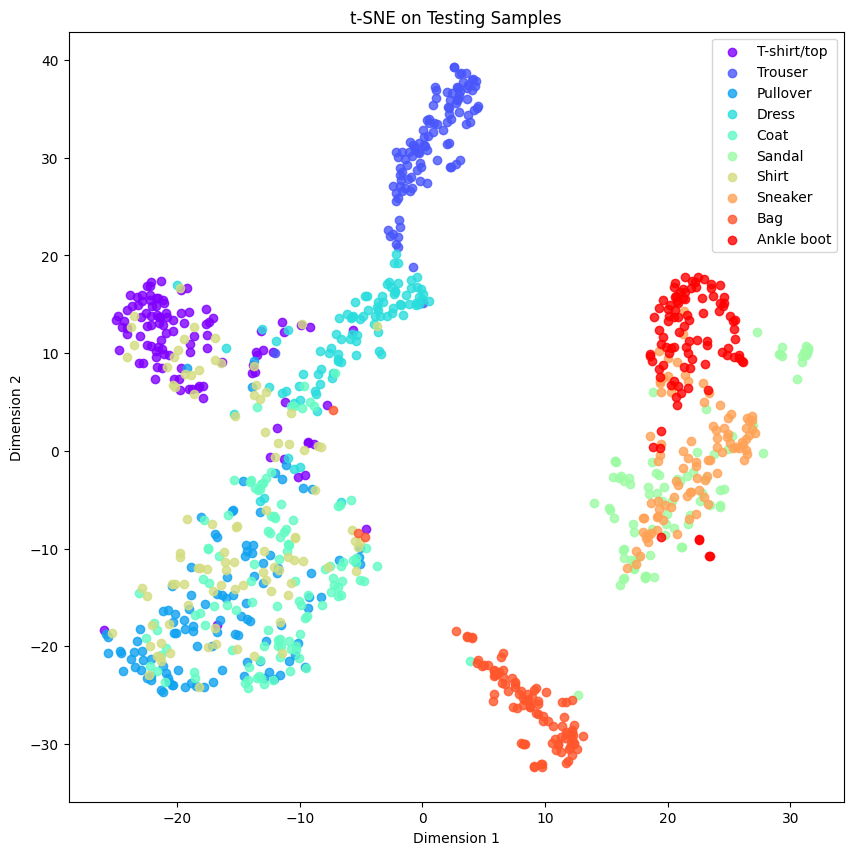

In [ ]:
obj_categories = [
    'T-shirt/top','Trouser','Pullover','Dress',
    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)

лабка

In [ ]:
from tensorflow.keras.utils import img_to_array, array_to_img
from sklearn.model_selection import train_test_split
import os
import numpy as np
import pandas as pd
from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
x_train, x_test = x_train[:8000], x_test[:1000]
y_train, y_test = y_train[:8000], y_test[:1000]

In [ ]:
x_train=np.dstack([x_train] * 3)
x_test=np.dstack([x_test] * 3)
x_train.shape, x_test.shape

((8000, 28, 84), (1000, 28, 84))

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 3)
x_test = x_test.reshape(-1, 28, 28, 3)

print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (8000, 28, 28, 3) 255
Testing (1000, 28, 28, 3) 255


In [ ]:
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((128, 128))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((128, 128))) for im in x_test])
x_train.shape, x_test.shape

((8000, 128, 128, 3), (1000, 128, 128, 3))

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [ ]:
x_train, x_valid, train_label, valid_label = train_test_split(x_train,y_train_one_hot,test_size=0.2,random_state=13)

моделька

In [ ]:
from keras.models import Model
from tensorflow.keras.layers import concatenate
from keras.layers import Conv2D , MaxPool2D , Input, Concatenate, GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation , BatchNormalization, ReLU, Flatten
from tensorflow.keras import optimizers
from keras import models, layers, callbacks, initializers
from tensorflow.keras.applications import Xception

In [ ]:
from keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from keras.models import Model

# Xception feature extraction model
def XceptionFeatureExtractor():
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape)

    # Entry flow
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same')(x)

    x = SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(128, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(256, (1, 1), padding='same', activation='relu')(x)
    x = SeparableConv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = SeparableConv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Middle flow
    for i in range(8):
        residual = x
        x = SeparableConv2D(512, (3, 3), padding='same', activation='relu')(x)
        x = SeparableConv2D(512, (3, 3), padding='same', activation='relu')(x)
        x = SeparableConv2D(512, (3, 3), padding='same', activation='relu')(x)
        x = x + residual

    # Exit flow
    residual = Conv2D(1024, (1, 1), strides=(2, 2), padding='same')(x)
    x = SeparableConv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = SeparableConv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', activation='relu')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', activation='relu')(x)

    model = Model(input_layer, x)

    return model

In [ ]:
model = XceptionFeatureExtractor()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 64, 64, 64)   18496       ['conv2d_4[0][0]']               
                                                                                                  
 separable_conv2d (SeparableCon  (None, 64, 64, 128)  8896       ['conv2d_5[0][0]']           

In [ ]:
train_features = model.predict(x_train, batch_size=64, verbose=1)
test_features = model.predict(x_test, batch_size=64, verbose=1)
val_features = model.predict(x_valid, batch_size=64, verbose=1)

25/25 [==============================] - 1s 30ms/step


In [ ]:
train_features.shape

(6400, 2, 2, 1024)

In [ ]:
def xception_classif(num_classes = 1000):
    # input_layer = Input(shape=(128, 128, 3))
    # feature_tensor = feature_extractor_model(input_layer)

    # # Classification layer
    # flat = Flatten()(feature_tensor)
    # dropout = Dropout(0.5)(flat)
    # dense = Dense(1000, activation='relu')(dropout)
    # dense = Dense(500, activation='relu')(dropout)
    # dense = Dense(250, activation='relu')(dropout)
    # dense = Dense(100, activation='relu')(dropout)
    # dense = Dense(10, activation='softmax')(dropout)

    # model = Xception(inputs=input_layer, outputs=dense)
    # Визначте архітектуру моделі
    input_tensor = Input(shape=(128, 128, 3))

    # Дублюйте канали кольору, щоб створити 3-канальне зображення
    concat_layer = Concatenate(axis=-1)([input_tensor, input_tensor, input_tensor])

    # Використайте Xception без верхнього шару
    xception = Xception(include_top=False, weights=None, input_tensor=concat_layer)
    x = xception.outputs[0]

    x = GlobalAveragePooling2D()(x)
    # x = Dense(1000, activation='relu')(x)
    output_tensor = Dense(10, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

for layer in model.layers:
    layer.trainable = False

class_model = xception_classif()

In [ ]:
class_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 128, 128, 9)  0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   2592        ['concatenate[0][0]']      

In [ ]:
class_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
reduce_lr = callbacks.ReduceLROnPlateau(
    factor=0.2,
    patience=2,
    verbose=1,
    cooldown=2
)

In [ ]:
valid_label

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
history = class_model.fit(
    x_train,
    train_label,
    batch_size=64,
    epochs=10,
    validation_data=(x_valid, valid_label),
    callbacks=[reduce_lr]
)

Epoch 1/10
100/100 [==============================] - 71s 342ms/step - loss: 0.7049 - accuracy: 0.7431 - val_loss: 2.3037 - val_accuracy: 0.1069 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - 33s 328ms/step - loss: 0.4608 - accuracy: 0.8338 - val_loss: 2.3128 - val_accuracy: 0.1069 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.3831 - accuracy: 0.8583
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
100/100 [==============================] - 34s 339ms/step - loss: 0.3831 - accuracy: 0.8583 - val_loss: 2.3137 - val_accuracy: 0.1144 - lr: 0.0010
Epoch 4/10
100/100 [==============================] - 33s 335ms/step - loss: 0.2326 - accuracy: 0.9144 - val_loss: 2.3703 - val_accuracy: 0.1119 - lr: 2.0000e-04
Epoch 5/10
100/100 [==============================] - 33s 332ms/step - loss: 0.1477 - accuracy: 0.9466 - val_loss: 2.1837 - val_accuracy: 0.3187 - lr: 2.0000e-04
Epoch 6/10
100/100 [====================

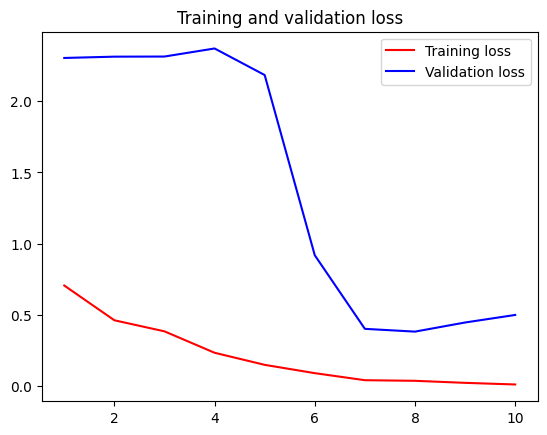

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuray = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()